# Johns Hopkins COVID-19 Dataset in Pandas

In [1]:
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

plt.style.use("ggplot")

## Read the data

At first, and for the new days, the data is read from the JHU GitHub repository.

To avoid repeated downloads, a daily _.csv_ file is stored locally.

In [2]:
from get_jhu_local import get_all_days
df = get_all_days()

Not a valid file: data/09-22-2020.csv
This is common behavior for today's (still empty) dataframe.


## Per-country data frames

In [3]:
c = lambda name: df.xs(name, level="Country_Region").groupby("Last_Update").sum()

be = c("Belgium")
ch = c("Switzerland")
cr = c("Croatia")
de = c("Germany")
es = c("Spain")
fr = c("France")
it = c("Italy")
lu = c("Luxembourg")
uk = c("United Kingdom")
us = c("US")

rlp = df.xs("Rheinland-Pfalz", level="Province_State").droplevel(["Country_Region", "Admin2"])

countries = dict(
    BE=be, CH=ch, CR=cr, DE=de, 
    ES=es, FR=fr, IT=it, LU=lu, 
    UK=uk, US=us, RLP=rlp
)

In [4]:
with open("population.csv") as f:
    pop = dict(filter(None, csv.reader(f)))

## Usage examples

In [5]:
code_list = ["DE", "ES", "FR", "UK", "US"]

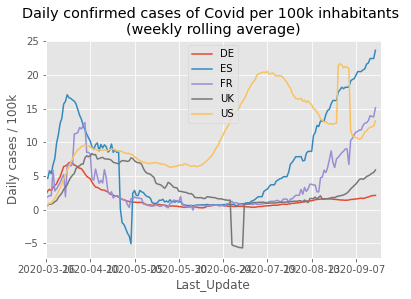

In [6]:
def daily_new_cases(code):
    dc = countries[code].ΔConfirmed.rolling(7, center=True).mean()
    dc = dc[dc.index > "2020-03-15"]
    return (dc / float(pop[code])).plot(label=code)

for country_code in code_list:
    daily_new_cases(country_code)

plt.legend()
plt.ylabel("Daily cases / 100k")
plt.title("Daily confirmed cases of Covid per 100k inhabitants \n(weekly rolling average)")
#plt.ylim((0, .05))
plt.savefig("img/covid_weekly.png", dpi=500)

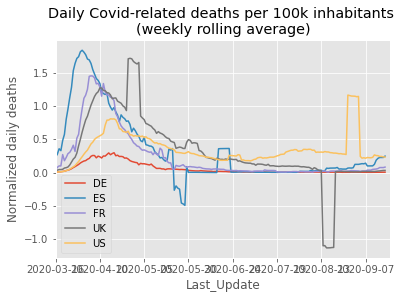

In [7]:
def daily_new_deaths(code):
    dc = countries[code].ΔDeaths.rolling(7, center=True).mean()
    dc = dc[dc.index > "2020-03-15"]
    return (dc / float(pop[code])).plot(label=code)

for country_code in code_list:
    daily_new_deaths(country_code)

plt.legend()
plt.ylabel("Normalized daily deaths")
plt.title("Daily Covid-related deaths per 100k inhabitants \n(weekly rolling average)")
#plt.ylim((0, .05))
plt.savefig("img/covid_deaths_weekly.png", dpi=500)

## Per Bundesland

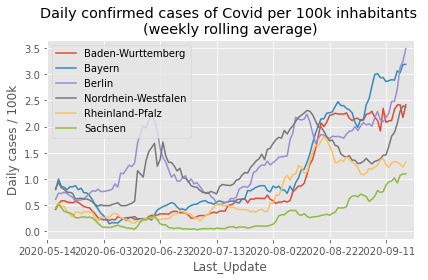

In [8]:
with open("population_bundesland.csv") as f:
    pop_bl = dict(filter(None, csv.reader(f)))

laender_of_interest = (
    'Rheinland-Pfalz','Baden-Wurttemberg', "Bayern", "Berlin", 'Nordrhein-Westfalen', 'Sachsen'   
)
# laender_of_interest = list(pop_bl.keys())

l = df.xs("Germany", level="Country_Region")
rows_per_day = l[l.columns[0]].groupby("Last_Update").count()
first_day_with_lander_info = min(rows_per_day[rows_per_day  >= 16].index)
laender = l[l.index.get_level_values("Last_Update") >= first_day_with_lander_info]
laender = laender.droplevel(["Admin2"])
for land, l_df in laender.groupby("Province_State"):
    if land not in laender_of_interest: continue
    l_df.index = l_df.index.get_level_values("Last_Update") 
    (l_df.ΔConfirmed.rolling(7, center=True).mean()
      / float(pop_bl[land])).plot(label=land)

plt.legend()
plt.ylabel("Daily cases / 100k")
plt.title("Daily confirmed cases of Covid per 100k inhabitants \n(weekly rolling average)")
plt.tight_layout()
plt.savefig("img/covid_land_weekly.png", dpi=500)